In [18]:
import numpy as np
import cv2
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn import svm
from keras.preprocessing import image
import tensorflow as tf
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K

In [2]:
EPOCHS = 24
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C:\\Users\\vihaan\\Desktop\\plant_disease_dataset'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)


[INFO] Spliting data to train, test


In [10]:
#array modification
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [12]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

C:\Users\vihaan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/24
73/73 [==============================] - 392s 5s/step - loss: 0.8574 - accuracy: 0.1881 - precision: 0.2756 - recall: 0.0722 - val_loss: 0.4469 - val_accuracy: 0.0525 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/24
73/73 [==============================] - 356s 5s/step - loss: 0.4407 - accuracy: 0.2082 - precision: 0.2961 - recall: 0.0620 - val_loss: 0.4975 - val_accuracy: 0.0643 - val_precision: 0.0635 - val_recall: 0.0626
Epoch 3/24
73/73 [==============================] - 349s 5s/step - loss: 0.2199 - accuracy: 0.3889 - precision: 0.5962 - recall: 0.2004 - val_loss: 0.4788 - val_accuracy: 0.0711 - val_precision: 0.0860 - val_recall: 0.0677
Epoch 4/24
73/73 [==============================] - 345s 5s/step - loss: 0.1714 - accuracy: 0.5398 - precision: 0.6961 - recall: 0.3878 - val_loss: 0.3784 - val_accuracy: 0.1117 - val_precision: 0.1218 - val_recall: 0.1032
Epoch 5/24
73/73 [==============================] - 345s 5s/step - loss: 0.1521 - accuracy: 0.5940 -

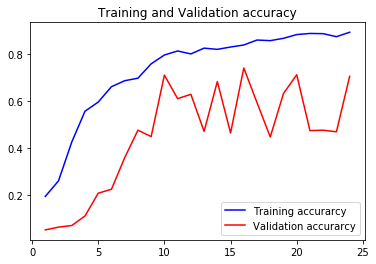

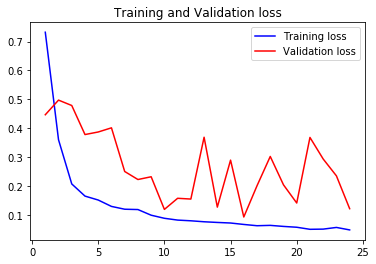

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 11s 596ms/step - loss: 0.1219 - accuracy: 0.7039 - precision: 0.7370 - recall: 0.6971
Test Accuracy: 70.38916945457458


[[[158. 141. 155.]
  [123. 106. 120.]
  [ 35.  18.  31.]
  ...
  [169. 150. 159.]
  [158. 139. 148.]
  [159. 140. 149.]]

 [[150. 133. 147.]
  [129. 112. 126.]
  [ 49.  32.  45.]
  ...
  [164. 145. 154.]
  [179. 160. 169.]
  [164. 145. 154.]]

 [[155. 138. 152.]
  [154. 137. 151.]
  [ 84.  67.  80.]
  ...
  [140. 121. 130.]
  [176. 157. 166.]
  [177. 158. 167.]]

 ...

 [[171. 151. 164.]
  [166. 146. 159.]
  [164. 144. 157.]
  ...
  [209. 192. 201.]
  [209. 192. 201.]
  [208. 191. 200.]]

 [[169. 149. 162.]
  [166. 146. 159.]
  [169. 149. 162.]
  ...
  [208. 191. 200.]
  [207. 190. 199.]
  [206. 189. 198.]]

 [[181. 161. 174.]
  [173. 153. 166.]
  [168. 148. 161.]
  ...
  [206. 189. 198.]
  [204. 187. 196.]
  [203. 186. 195.]]]


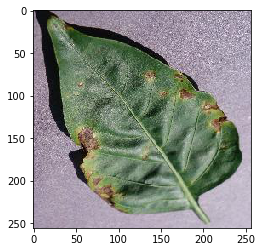

In [28]:
image_dir="C://Users//vihaan//Desktop//plant_disease_dataset//PlantVillage//Pepper__bell___Bacterial_spot//00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot3132.jpg"
img= image.load_img(image_dir)
plt.imshow(img)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
print(im)



In [20]:
result=model.predict(npp_image)

print(result)

[[6.2202173e-01 5.5532724e-02 6.4614795e-02 1.6743699e-04 1.1140950e-04
  1.2675900e-04 2.4920721e-01 4.0905373e-04 1.5191284e-05 2.9301872e-03
  2.0483381e-05 4.8129824e-03 5.2209039e-06 1.4144542e-05 1.0693501e-05]]


In [23]:
itemindex = np.where(result==np.max(result))
print(label_binarizer.classes_[itemindex[1][0]])

Pepper__bell___Bacterial_spot
